# Flow Matching with Classifier-Free Guidance & Library Size Conditioning

**Updates:**
1. **Training:** Uses OT-Flow Matching (Gaussian Conditional Probability Path).
2. **Conditioning:** Conditions on both **Cell Type** and **Library Size**.
3. **Sampling:** Uses Euler ODE integration
4. **Decoding:** Rescales latents and decodes to counts using Negative Binomial.

In [1]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Optional, List, Tuple
from scvi.distributions import NegativeBinomial

# Imports for VAE (Ensure autoencoder_utils.py is in the same directory)
try:
    from autoencoder_utils import NB_Autoencoder
except ImportError:
    # Fallback if file not found, defining minimal class for loading
    print("lol")
    class NB_Autoencoder(nn.Module):
        def __init__(self, num_features, latent_dim=50, hidden_dims=[512, 256]):
            super().__init__()
            self.num_features = num_features
            self.latent_dim = latent_dim
            # ... (Architecture assumed match)
            # Placeholder for loading state dict
            self.encoder = nn.Sequential(nn.Linear(num_features, 512), nn.ReLU(), nn.Linear(512, 256), nn.ReLU())
            self.mu = nn.Linear(256, latent_dim)
            self.logvar = nn.Linear(256, latent_dim)
            self.decoder = nn.Sequential(nn.Linear(latent_dim, 256), nn.ReLU(), nn.Linear(256, 512), nn.ReLU())
            self.mu_dec = nn.Linear(512, num_features)
            self.theta = nn.Parameter(torch.randn(num_features))
        def decode(self, z, library_size):
            h = self.decoder(z)
            mu = torch.softmax(self.mu_dec(h), dim=1) * library_size
            return {"mu": mu, "theta": self.theta}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [2]:
# ---- Configuration & Paths ----
input_file_path = "/dtu/blackhole/06/213542/paperdata/pbmc3k_train_with_latent.h5ad"
vae_model_path = "/dtu/blackhole/06/213542/paperdata/pbmc3k_train_nb_autoencoder.pt" # Path to trained VAE
flow_model_save_path = "/dtu/blackhole/06/213542/paperdata/lib_size_flow_model.pt"

os.makedirs(os.path.dirname(flow_model_save_path), exist_ok=True)

# Hyperparameters
batch_size = 256
num_epochs = 4000
learning_rate = 5e-4
latent_dim = 50
drop_prob = 0.1   # Classifier-free guidance dropout probability
guidance_scale = 2.0
n_steps = 50      # Euler integration steps

In [3]:
# ---- Load Data ----
adata = ad.read_h5ad(input_file_path)
latent = adata.obsm["X_latent"]
latent_tensor = torch.tensor(latent, dtype=torch.float32, device=device)

# Library Sizes
if "total_counts" in adata.obs:
    lib_sizes = adata.obs["total_counts"].values
else:
    lib_sizes = np.array(adata.X.sum(1)).flatten()

log_lib_sizes = np.log1p(lib_sizes)
log_lib_tensor = torch.tensor(log_lib_sizes, dtype=torch.float32, device=device).unsqueeze(1)

# Stats for normalization and sampling
lib_min, lib_max = log_lib_tensor.min(), log_lib_tensor.max()
lib_mean, lib_std = log_lib_tensor.mean(), log_lib_tensor.std()

# Cell Types
cell_types = adata.obs["cell_type"].astype(str).values
unique_types, inverse_idx = np.unique(cell_types, return_inverse=True)
num_cell_types = len(unique_types)
cell_type_idx = torch.tensor(inverse_idx, dtype=torch.long, device=device)

print(f"Data Shape: {latent.shape}")
print(f"Library Size: Min={lib_min:.2f}, Max={lib_max:.2f}, Mean={lib_mean:.2f}")
print(f"Cell Types: {unique_types}")

Data Shape: (2110, 50)
Library Size: Min=6.49, Max=7.86, Mean=7.42
Cell Types: ['B cells' 'CD14+ Monocytes' 'CD4 T cells' 'CD8 T cells' 'Dendritic cells'
 'FCGR3A+ Monocytes' 'Megakaryocytes' 'NK cells']


In [4]:
# ---- Flow Matching Classes (OT Path) ----

class EmpiricalDistribution(nn.Module):
    def __init__(self, data):
        super().__init__()
        self.register_buffer("data", data)
    def sample(self, n):
        idx = torch.randint(0, len(self.data), (n,), device=self.data.device)
        return self.data[idx]

class GaussianConditionalProbabilityPath:
    def __init__(self, p_data):
        self.p_data = p_data
    def sample_conditional_path(self, z, t):
        # Linear interpolation: t * z + (1-t) * noise
        # Note: Train_flow_cfg typically uses x1 (data) and x0 (noise)
        # Here we adapt to match the provided notebook logic:
        # Target is usually data, Source is noise.
        # path: x_t = t * x_1 + (1 - t) * x_0
        # vector field u_t = x_1 - x_0
        return t * z + (1 - t) * torch.randn_like(z)

    def conditional_vector_field(self, x_1, x_0):
        return x_1 - x_0

# ---- Neural Network (With Library Size) ----

class TimeEmbedder(nn.Module):
    def __init__(self, embed_dim=32):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim), nn.SiLU(),
            nn.Linear(embed_dim, embed_dim), nn.SiLU()
        )
        self.embed_dim = embed_dim
    def forward(self, t):
        # Sinusoidal embedding
        half_dim = self.embed_dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t * emb[None, :]
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=1)
        return self.mlp(emb)

class NeuralVectorField(nn.Module):
    def __init__(self, latent_dim, hidden_dim=256, time_embed_dim=64, lib_min=0, lib_max=10):
        super().__init__()
        self.x_proj = nn.Linear(latent_dim, hidden_dim)
        self.z_proj = nn.Linear(latent_dim, hidden_dim) # Type conditioning
        self.time_embedder = TimeEmbedder(time_embed_dim)
        
        # Library size embedding
        self.lib_min = lib_min
        self.lib_max = lib_max
        self.l_proj = nn.Sequential(
            nn.Linear(time_embed_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        in_dim = hidden_dim * 3 + time_embed_dim
        self. net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

    def forward(self, x, z, t, l):
        # x: current state, z: type condition, t: time, l: library size
        hx = self.x_proj(x)
        hz = self.z_proj(z)
        ht = self.time_embedder(t)
        
        # Library embedding (normalize first)
        l_norm = (l - self.lib_min) / (self.lib_max - self.lib_min)
        # Re-use time embedder logic for continuous scalar l
        hl_emb = self.time_embedder.forward(l_norm) 
        hl = self.l_proj(hl_emb)

        h = torch.cat([hx, hz, ht, hl], dim=-1)
        return self.net(h)

class CellTypeConditioner(nn.Module):
    def __init__(self, n_types, latent_dim):
        super().__init__()
        self.embed = nn.Embedding(n_types, latent_dim)
    def forward(self, idx):
        return self.embed(idx)

In [5]:
# ---- Initialize Models ----
vf_model = NeuralVectorField(latent_dim, lib_min=lib_min, lib_max=lib_max).to(device)
conditioner = CellTypeConditioner(num_cell_types, latent_dim).to(device)

optimizer = torch.optim.AdamW(list(vf_model.parameters()) + list(conditioner.parameters()), lr=learning_rate)

emp_dist = EmpiricalDistribution(latent_tensor)
path = GaussianConditionalProbabilityPath(emp_dist)

# Null token for classifier-free guidance
z_null = torch.zeros(1, latent_dim, device=device)

Training: 100%|██████████| 4000/4000 [01:01<00:00, 65.54it/s]


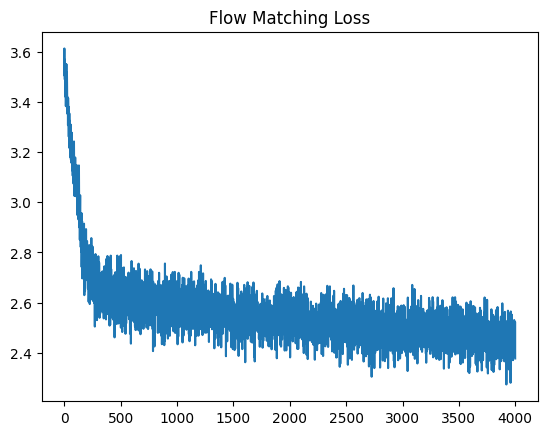

In [6]:
# ---- Training Loop (Flow Matching) ----
loss_history = []

vf_model.train()
conditioner.train()

for epoch in tqdm(range(num_epochs), desc="Training"):
    # 1. Sample Batch
    idx = torch.randint(0, len(latent_tensor), (batch_size,), device=device)
    x_1 = latent_tensor[idx] # Target data
    x_0 = torch.randn_like(x_1) # Source noise
    
    # Conditions
    batch_types = cell_type_idx[idx]
    batch_libs = log_lib_tensor[idx]

    # 2. Sample Time
    t = torch.rand(batch_size, 1, device=device)

    # 3. Compute Path (Interpolation)
    # x_t = t * x_1 + (1-t) * x_0
    x_t = t * x_1 + (1 - t) * x_0
    
    # 4. Compute Target Vector Field
    # u_t = x_1 - x_0
    u_target = x_1 - x_0

    # 5. Conditioning w/ Drop (CFG)
    z_emb = conditioner(batch_types)
    drop_mask = (torch.rand(batch_size, 1, device=device) < drop_prob)
    z_used = torch.where(drop_mask, z_null, z_emb)

    # 6. Prediction
    v_pred = vf_model(x_t, z_used, t, batch_libs)

    # 7. Loss
    loss = F.mse_loss(v_pred, u_target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

plt.plot(loss_history)
plt.title("Flow Matching Loss")
plt.show()

In [7]:
# ---- Save Models ----
torch.save({
    'vf_state': vf_model.state_dict(),
    'cond_state': conditioner.state_dict()
}, flow_model_save_path)
print(f"Saved models to {flow_model_save_path}")

Saved models to /dtu/blackhole/06/213542/paperdata/lib_size_flow_model.pt


In [8]:
# ==================================================================================
# SAMPLING AND DECODING 
# ==================================================================================

# 1. Load VAE for Decoding
# We need the VAE to map latents -> gene counts
vae = NB_Autoencoder(num_features=adata.n_vars, latent_dim=latent_dim)
try:
    vae.load_state_dict(torch.load(vae_model_path, map_location=device))
    vae.to(device)
    vae.eval()
    print("VAE loaded successfully.")
except FileNotFoundError:
    print(f"Warning: VAE model not found at {vae_model_path}. Decoding will fail.")

# 2. Euler Integration Simulator 
class LearnedVectorFieldODE:
    def __init__(self, vf_model, conditioner, z_target, l_target, guidance_scale=2.0):
        self.vf = vf_model
        self.z = conditioner(z_target)
        self.l = l_target
        self.scale = guidance_scale
        self.z_null = torch.zeros_like(self.z)
    
    def drift(self, x, t):
        # Duplicate inputs for Cond and Uncond pass
        x_in = torch.cat([x, x], dim=0)
        t_in = torch.cat([t, t], dim=0)
        l_in = torch.cat([self.l, self.l], dim=0)
        z_in = torch.cat([self.z, self.z_null], dim=0)
        
        v_out = self.vf(x_in, z_in, t_in, l_in)
        v_cond, v_uncond = v_out.chunk(2, dim=0)
        
        # CFG Formula: v = v_uncond + s * (v_cond - v_uncond)
        return v_uncond + self.scale * (v_cond - v_uncond)

def generate_samples(target_type_idx, num_samples, fix_library_size=True):
    vf_model.eval()
    conditioner.eval()
    
    # A. Setup Latents
    #x = torch.randn(num_samples, latent_dim, device=device) # Noise x0
    x = torch.rand(num_samples, latent_dim, device=device)
    # B. Setup Conditions
    # 1. Cell Typ

    type_tensor = torch.full((num_samples,), target_type_idx, dtype=torch.long, device=device)

    # 2. Library Size
    # We can either sample from the empirical distribution or fix it for evaluation
    if fix_library_size:
        # Fix to mean for cleaner evaluation
        l_val = lib_mean.item()
        l_tensor = torch.full((num_samples, 1), l_val, device=device)
    else:
        # Sample from normal approx of log-libs
        l_tensor = torch.normal(lib_mean.item(), lib_std.item(), (num_samples, 1), device=device)

    # C. ODE Integration (Euler)
    

    ode = LearnedVectorFieldODE(vf_model, conditioner, type_tensor, l_tensor, guidance_scale)
    dt = 1.0 / n_steps
    t = torch.zeros(num_samples, 1, device=device)
    
    print(f"Sampling {num_samples} cells (Type {target_type_idx})...")
    with torch.no_grad():
        for _ in range(n_steps):
            v = ode.drift(x, t)
            x = x + v * dt
            t = t + dt
            
    return x

"""['B cells' 'CD14+ Monocytes' 'CD4 T cells' 'CD8 T cells' 'Dendritic cells'
 'FCGR3A+ Monocytes' 'Megakaryocytes' 'NK cells']"""

target_idx = 2
n_gen = 200
generated_latents = generate_samples(target_idx, n_gen)

# 4. Rescaling
# "generated_rescaled = (generated_tensor - generated_tensor.mean(dim=0)) / std_gen * std_orig + latent_tensor.mean(dim=0)"
std_orig = latent_tensor.std(dim=0)
mean_orig = latent_tensor.mean(dim=0)
std_gen = generated_latents.std(dim=0)
mean_gen = generated_latents.mean(dim=0)

generated_rescaled = (generated_latents - mean_gen) / std_gen * std_orig + mean_orig

# 5. Decoding with Fixed Library Size
target_lib_size = 1000 

print("Decoding to counts...")
with torch.no_grad():
    outputs = vae.decode(generated_rescaled, target_lib_size)
    mu = outputs["mu"]
    theta = torch.exp(outputs["theta"])
    
    # Sample from Negative Binomial
    nb_dist = NegativeBinomial(mu=mu, theta=theta)
    X_gen_counts = nb_dist.sample().cpu().numpy()

print(f"Final Generated Counts Shape: {X_gen_counts.shape}")



# Optional: Save or Plot
# sc.AnnData(X=X_gen_counts).write(...)

VAE loaded successfully.
Sampling 200 cells (Type 2)...
Decoding to counts...
Final Generated Counts Shape: (200, 8573)


In [9]:
import anndata as ad
import os

# Paths
save_dir = "/dtu/blackhole/06/213542/paperdata/"
os.makedirs(save_dir, exist_ok=True)
counts_save_path = os.path.join(save_dir, "new_generated_pbmc3k_counts.h5ad")
latents_save_path = os.path.join(save_dir, "new_generated_pbmc3k_latents.pt")

# --- 1. Save Final Counts (for Scanpy/Evaluation) ---
# Create AnnData from the generated counts
adata_gen = ad.AnnData(X=X_gen_counts)

# Transfer gene names from the original data (if available)
if 'adata' in globals():
    adata_gen.var_names = adata.var_names

# Add metadata (e.g., which cell type was generated)
# Assuming 'target_type_idx' and 'unique_types' exist from previous cells
if 'unique_types' in globals() and 'target_type_idx' in globals():
    cell_type_name = unique_types[target_type_idx]
    adata_gen.obs['cell_type'] = cell_type_name
    
adata_gen.write(counts_save_path)
print(f"Saved generated counts to: {counts_save_path}")

Saved generated counts to: /dtu/blackhole/06/213542/paperdata/new_generated_pbmc3k_counts.h5ad


In [28]:
# ==================================================================================
# GENERATE AND SAVE EVALUATION DATA (H5AD)
# ==================================================================================

import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import os

# 1. GENERATE SYNTHETIC DATA (Balanced across all types)
# ------------------------------------------------------------------
n_per_type = 100  # Number of cells to generate per type
generated_list = []
gen_labels_list = []

print(f"Generating {n_per_type} cells for each of {num_cell_types} cell types...")

for type_idx in range(num_cell_types):
    # Generate batch for this specific type
    # Fix library size to mean for cleaner evaluation
    batch = generate_samples(target_type_idx=type_idx, num_samples=n_per_type, fix_library_size=True)
    
    generated_list.append(batch)
    
    # Store the label name (e.g., 'B cells')
    type_name = unique_types[type_idx]
    gen_labels_list.extend([type_name] * n_per_type)

# Concatenate all generated batches (Latent Space)
X_gen = torch.cat(generated_list, dim=0).cpu().numpy()
labels_gen = np.array(gen_labels_list)

# 2. PREPARE REAL DATA (Reference)
# ------------------------------------------------------------------
# Use the latent_tensor loaded at the start of the notebook
X_real = latent_tensor.cpu().numpy()
labels_real = cell_types  # The original string labels

# Optional: Subsample real data to match generated size if it's too large
if len(X_real) > len(X_gen):
    idx_sub = np.random.choice(len(X_real), len(X_gen), replace=False)
    X_real = X_real[idx_sub]
    labels_real = labels_real[idx_sub]

# 3. COMBINE INTO ANNDATA
# ------------------------------------------------------------------
# Stack features
X_combined = np.concatenate([X_real, X_gen], axis=0)

# Create metadata arrays
condition_labels = (['Real'] * len(X_real)) + (['Generated'] * len(X_gen))
type_labels_combined = np.concatenate([labels_real, labels_gen], axis=0)

# Create AnnData object
adata_eval = ad.AnnData(X=X_combined)
adata_eval.obs['Condition'] = condition_labels
adata_eval.obs['Cell_Type'] = type_labels_combined

# 4. SAVE TO H5AD
# ------------------------------------------------------------------
# Save in the same directory as the input file
save_dir = os.path.dirname(input_file_path)
save_path = os.path.join(save_dir, "eval_data_latents.h5ad")

print(f"Saving evaluation data to: {save_path}")
adata_eval.write_h5ad(save_path)
print("Done.")

Generating 100 cells for each of 8 cell types...
Sampling 100 cells (Type 0)...
Sampling 100 cells (Type 1)...
Sampling 100 cells (Type 2)...
Sampling 100 cells (Type 3)...
Sampling 100 cells (Type 4)...
Sampling 100 cells (Type 5)...
Sampling 100 cells (Type 6)...
Sampling 100 cells (Type 7)...
Saving evaluation data to: /dtu/blackhole/06/213542/paperdata/eval_data_latents.h5ad
Done.


In [15]:
# ==================================================================================
# UMAP EVALUATION: REAL (TEST) vs GENERATED
# ==================================================================================

import scanpy as sc
import pandas as pd
import numpy as np

# 1. GENERATE SYNTHETIC DATA (Balanced across all types)
# ------------------------------------------------------------------
n_per_type = 100  # Number of cells to generate per type
generated_list = []
gen_labels_list = []

print(f"Generating {n_per_type} cells for each of {num_cell_types} cell types...")

for type_idx in range(num_cell_types):
    # Generate batch for this specific type
    # Note: We fix library size to mean for cleaner evaluation, or set fix_library_size=False for more variance
    batch = generate_samples(target_type_idx=type_idx, num_samples=n_per_type, fix_library_size=True)
    
    generated_list.append(batch)
    
    # Store the label name (e.g., 'B cells') for plotting
    type_name = unique_types[type_idx]
    gen_labels_list.extend([type_name] * n_per_type)

# Concatenate all generated batches
X_gen = torch.cat(generated_list, dim=0).cpu().numpy()
labels_gen = np.array(gen_labels_list)

# 2. PREPARE REAL DATA (Reference)
# ------------------------------------------------------------------
# We simply move the GPU tensor to CPU numpy
# You can also sample a subset if the dataset is too huge
X_real = latent_tensor.cpu().numpy()
labels_real = cell_types  # The original string labels loaded earlier

# Optionally subsample real data to match generated size if needed
if len(X_real) > len(X_gen):
    idx_sub = np.random.choice(len(X_real), len(X_gen), replace=False)
    X_real = X_real[idx_sub]
    labels_real = labels_real[idx_sub]

# 3. COMBINE INTO ANNDATA FOR UMAP
# ------------------------------------------------------------------
# Stack features
X_combined = np.concatenate([X_real, X_gen], axis=0)

# Create "Condition" labels (Real vs Generated)
condition_labels = (['Real'] * len(X_real)) + (['Generated'] * len(X_gen))

# Create "Cell Type" labels
type_labels_combined = np.concatenate([labels_real, labels_gen], axis=0)

# Create AnnData object
adata_eval = ad.AnnData(X=X_combined)
adata_eval.obs['Condition'] = condition_labels
adata_eval.obs['Cell Type'] = type_labels_combined

# 4. COMPUTE UMAP
# ------------------------------------------------------------------
print("Computing Neighbors and UMAP...")
sc.pp.neighbors(adata_eval, use_rep='X')
sc.tl.umap(adata_eval)


Generating 50 cells for each of 8 cell types...
Sampling 50 cells (Type 0)...
Sampling 50 cells (Type 1)...
Sampling 50 cells (Type 2)...
Sampling 50 cells (Type 3)...


KeyboardInterrupt: 